In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
dataset = pd.read_csv("Speed_Dating_Data.csv", encoding="ISO-8859-1")
iid_group = dataset.groupby(by=["iid"])

# The question 'How do you think others perceive you?' is not answered for all the dataset
data_wth_perception = []
data_wthout_perception = []

ftr_list_1 = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
ftr_list_2 = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
percep_ftr_list = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
result_ftr_list = ['you_call', 'them_cal']

In [4]:
attribute_list_1 = ['attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']
attribute_list_2 = ['attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2']
X = []
Y = []

for subject in iid_group:
    if np.isnan(subject[1]['attr5_2'].iat[0]) or\
        np.isnan(subject[1]['attr3_2'].iat[0]) or\
        np.isnan(subject[1]['them_cal'].iat[0]):
        continue
    
    x_to_insert = []
    
    for i in range(len(attribute_list_1)):
        x_to_insert.append(subject[1][attribute_list_1[i]].iat[0])
        x_to_insert.append(subject[1][attribute_list_2[i]].iat[0])
    
    X.append(x_to_insert)
    
    if subject[1]['them_cal'].iat[0] == 0:
        Y.append(0)
    else:
        Y.append(1)

X = np.array(X)
Y = np.transpose(np.array([Y]))

In [5]:
div_bound = int(X.shape[0] * 0.7)
X_tr = X[:div_bound, :]
Y_tr = Y[:div_bound, :]
X_te = X[div_bound:, :]
Y_te = Y[div_bound:, :]
X_to_use = X
Y_to_use = Y


print("\n X shape: ", X.shape,\
      "\n Y shape: ", Y.shape,\
      "\n X tr shape: ", X_tr.shape,\
      "\n X te shape: ", X_te.shape,\
      "\n Y tr shape: ", Y_tr.shape,\
      "\n Y te shape: ", Y_te.shape)


 X shape:  (121, 10) 
 Y shape:  (121, 1) 
 X tr shape:  (84, 10) 
 X te shape:  (37, 10) 
 Y tr shape:  (84, 1) 
 Y te shape:  (37, 1)


In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers
from keras.regularizers import L1L2

In [7]:
import keras.backend as K
K.clear_session()

seed = 9
np.random.seed(seed)

In [8]:
from keras import optimizers
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lost = np.array([])
        self.val_acc = np.array([])
 
    def on_batch_end(self, batch, logs={}):
        self.lost = np.append(self.lost, logs.get('loss'))
        
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc = np.append(self.val_acc, logs.get('val_acc'))

In [9]:


# ===========
# Train Neural Network Model
#
# Output: [model, loss_history]
#
# ===========

def Speeddate_Train(X_tr, Y_tr, X_te, Y_te, act='sigmoid', hidden_n = 0, opt='Adam',\
                    dropout_r=0, lam_l1=0, lam_l2=0, epo=20, bat=1):
    history_cb = LossHistory()
    K.clear_session()
    
    model = Sequential()
    model.add(Dense(X_tr.shape[1], input_shape=(X_tr.shape[1],), activation=act,\
                    kernel_regularizer = L1L2(lam_l1, lam_l2), name='hidden'))
    model.add(Dropout(dropout_r))
    
    # Insert hidden layers
    for i in range(hidden_n):
        model.add(Dense(X_tr.shape[1], input_shape=(X_tr.shape[1],), activation=act,\
                        kernel_regularizer = L1L2(lam_l1, lam_l2), name='hidden' + str(i)))
        model.add(Dropout(dropout_r))
    
    model.add(Dense(Y_tr.shape[1], activation='softmax', kernel_regularizer = L1L2(lam_l1, lam_l2), name='output'))
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_tr, Y_tr, epochs=epo, batch_size=bat, validation_data=(X_te, Y_te),
         callbacks=[history_cb], verbose=0)
    
    return [model, history_cb]

def plot_loss_acc(history_cb, X_tr, bat=1):
    plt.plot(range(len(history_cb.val_acc)), history_cb.val_acc, 'c-')#np.log(alphas), ridge_errors, 'co')
    plt.xlabel('Epoch')
    plt.ylabel('val_acc')
    plt.show()

    plt.semilogy(np.array(range(len(history_cb.lost)))* bat / X_tr.shape[0],
                 history_cb.lost, 'c-')
    plt.xlabel('batch')
    plt.ylabel('Loss values')
    plt.show()   

In [10]:
from sklearn.model_selection import KFold

def Speeddate_Train_K(X, Y, act='sigmoid', hidden_n = 0, opt='Adam',\
                    dropout_r=0, lam_l1=0, lam_l2=0, epo=20, bat=1, k=7, seed=9):

    kfold = KFold(n_splits = k, shuffle=True, random_state = seed)
    cvscores = []
    for train,test in kfold.split(X, Y):
        [model ,history_cb] = Speeddate_Train(X[train], Y[train], X[train], Y[train],\
                                              hidden_n = hidden_n, opt=opt,\
                                            lam_l1=lam_l1, lam_l2=lam_l2, dropout_r = dropout_r,\
                                              epo=epo, bat=bat)

        scores = model.evaluate(X[test], Y[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1]*100)

    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return [np.mean(cvscores), np.std(cvscores)]

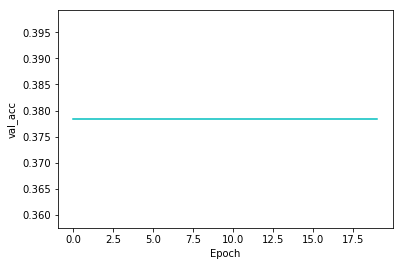

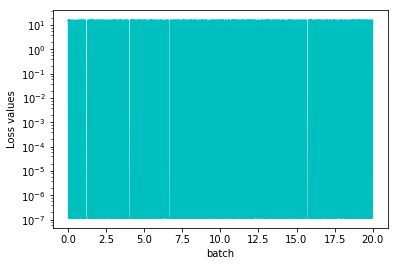

acc: 55.56%
acc: 38.89%


In [ ]:
#=======================
#   Start Training
#=======================

activation_set = ['sigmoid', 'tanh', 'relu']
hidden_n_set = [0, 5, 10]
opt_set = ['SGD', 'Adam', 'Nadam']
dropout_set = [0, 0.2, 0.5]
lam_l1_set = [0, 0.001, 0.1]
lam_l2_set = [0, 0.001, 0.1]

l1 = 0
l2 = 0
d_r = 0
o = 'Adam'
a = 'sigmoid'
n = 0

seed = 999
np.random.seed(seed)

[model ,history_cb] = Speeddate_Train(X_tr, Y_tr, X_te, Y_te, hidden_n = n, opt=o,\
                                    act = a, lam_l1=l1, lam_l2=l2, dropout_r = d_r, epo=20, bat=1)

plot_loss_acc(history_cb, X_tr)

[score, std] = Speeddate_Train_K(X_to_use, Y_to_use, \
                            act=a, hidden_n=n, opt=o,\
                            dropout_r=d_r, lam_l1=l1, lam_l2=l1, epo=20, bat=5, k=7, seed=seed)